In [15]:
# Load the libraries
import spatialdata as sd
import scanpy as sc
import pandas as pd
import matplotlib.pyplot as plt
import squidpy as sq
from spatialdata import get_extent
from spatialdata import bounding_box_query
from spatialdata import match_element_to_table
import spatialdata_plot
import numpy as np
import matplotlib.cm as cm
from matplotlib.colors import LinearSegmentedColormap
from datatree import DataTree
from scipy.stats import spearmanr
from scipy.spatial.distance import cosine
from sklearn.neighbors import KernelDensity
from easydecon.easydecon import *
from easydecon.config import *
from spatialdata_plot.pl.utils import set_zero_in_cmap_to_transparent
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.colors import ListedColormap
from matplotlib.colors import ListedColormap, BoundaryNorm




pd.set_option('display.max_rows', 10)

In [16]:
set_n_jobs(5) #if you have more than 5 cores, you can increase this number

In [17]:
# load a compatible color map for the spatial data
new_cmap = set_zero_in_cmap_to_transparent(cmap="viridis")
#this is a discrete colormap for the spatial data, manually selected colors. You can change the colors if you want.

discrete_cmap = ListedColormap([
  '#ffe119', 
  '#4363d8', 
  '#f58231', 
    '#46f0f0', 
    '#008080', '#9a6324', '#ff0000',
    '#00FF00', '#808000', '#ffd8b1', '#000075',
    '#ff6347', '#415164', 
    '#0000cd'
])

# Loading the data and QC
Now we load the spatial data and the target data. We use 8um bin size which is an acceptable resolution. Set the sample id and point spaceranger output directory. 

You should change this based on your dataset location.Now we load the spatial data and the target data. We use 8um bin size which is an acceptable resolution. Set the sample id and point spaceranger output directory.

In [18]:
bin_size=8
sample_id="sampleP2"

sdata=spatialdata_io.visium_hd("../../sampleP2/binned_outputs/",fullres_image_file="../../sampleP2/Visium_HD_Human_Colon_Cancer_tissue_image.btf",
                               bin_size=bin_size,dataset_id=sample_id,load_all_images=False)
sdata

/Users/sium/miniconda/envs/easydecon_test1/lib/python3.11/site-packages/anndata/_core/anndata.py:1820: UserWarning: Variable names are not unique. To make them unique, call `.var_names_make_unique`.
  utils.warn_names_duplicates("var")


SpatialData object
├── Images
│     ├── 'sampleP2_full_image': DataTree[cyx] (3, 48740, 75250), (3, 24370, 37625), (3, 12185, 18812), (3, 6092, 9406), (3, 3046, 4703)
│     ├── 'sampleP2_hires_image': DataArray[cyx] (3, 3886, 6000)
│     └── 'sampleP2_lowres_image': DataArray[cyx] (3, 389, 600)
├── Shapes
│     └── 'sampleP2_square_008um': GeoDataFrame shape: (545913, 1) (2D shapes)
└── Tables
      └── 'square_008um': AnnData (545913, 18085)
with coordinate systems:
    ▸ 'downscaled_hires', with elements:
        sampleP2_hires_image (Images), sampleP2_square_008um (Shapes)
    ▸ 'downscaled_lowres', with elements:
        sampleP2_lowres_image (Images), sampleP2_square_008um (Shapes)
    ▸ 'global', with elements:
        sampleP2_full_image (Images), sampleP2_square_008um (Shapes)

INFO     Dropping coordinate system 'downscaled_lowres' since it doesn't have relevant elements.                   
INFO     Dropping coordinate system 'global' since it doesn't have relevant elements.                              


/Users/sium/miniconda/envs/easydecon_test1/lib/python3.11/site-packages/spatialdata/_core/_elements.py:96: UserWarning: Key `sampleP2_square_008um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


INFO     Dropping coordinate system 'downscaled_hires' since it doesn't have relevant elements.                    
INFO     Dropping coordinate system 'downscaled_lowres' since it doesn't have relevant elements.                   


/Users/sium/miniconda/envs/easydecon_test1/lib/python3.11/site-packages/spatialdata/_core/_elements.py:116: UserWarning: Key `square_008um` already exists. Overwriting it in-memory.
  self._check_key(key, self.keys(), self._shared_keys)


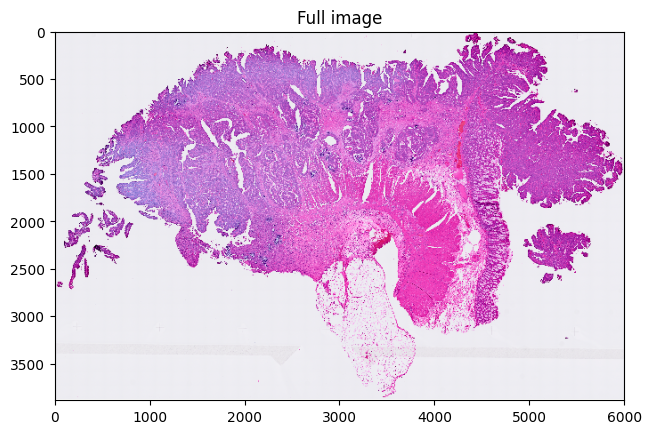

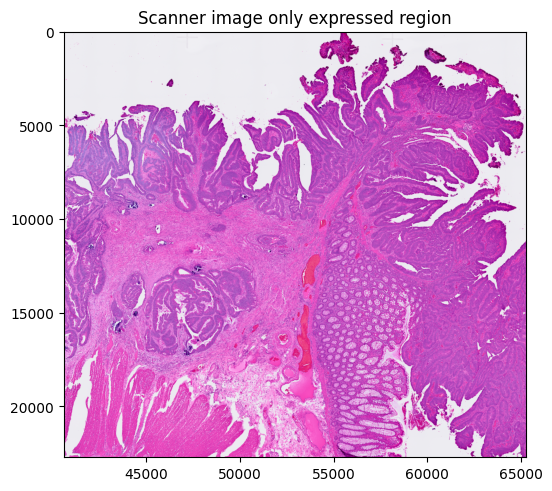

In [19]:
# to align the high resolution image with the spatial data, we need to run this part
data_extent=get_extent(sdata[f"{sample_id}_square_00{bin_size}um"])

queried_cytassist = bounding_box_query(
    sdata[f"{sample_id}_full_image"],
    min_coordinate=[data_extent["x"][0], data_extent["y"][0]],
    max_coordinate=[data_extent["x"][1], data_extent["y"][1]],
    axes=("x", "y"),
    target_coordinate_system="global",
)

sdata["queried_cytassist"]=queried_cytassist

for table in sdata.tables.values():
   table.var_names_make_unique()
   sc.pp.calculate_qc_metrics(table, inplace=True)
   sc.pp.filter_genes(table, min_cells=10)
   sc.pp.filter_cells(table, min_counts=10)
   sc.pp.normalize_total(table, inplace=True,target_sum=1e4)
   sc.pp.log1p(table)
   #sc.pp.scale(table)
   #sc.pp.pca(table)
   #sc.pp.neighbors(table)
   #sc.tl.umap(table)

#here we filter the spatial data to only include the cells that are in the table
sdata.shapes[f"{sample_id}_square_00{bin_size}um"]=sdata.shapes[f"{sample_id}_square_00{bin_size}um"][sdata.shapes[f"{sample_id}_square_00{bin_size}um"].index.isin(sdata.tables[f"square_00{bin_size}um"].obs["location_id"])]

sdata.pl.render_images(f"{sample_id}_hires_image").pl.show( title="Full image")
sdata.pl.render_images("queried_cytassist").pl.show( title="Scanner image only expressed region")

#dropping mitochondrial genes, this is optional
mt_genes = sdata.tables[f"square_00{bin_size}um"].var_names.str.startswith('MT-')
sdata.tables[f"square_00{bin_size}um"] = sdata.tables[f"square_00{bin_size}um"][:,~mt_genes]

We can run Easydecon on the subregion of the data. We also also use the entire section to run the spatial deconvolution but it is faster to run on the region of interest.
Lets select a subregion. You can check the coordinates of the region of interest from the image above.

In [20]:
sdata_small = sdata.query.bounding_box(
   min_coordinate=[42000, 12000], max_coordinate=[50000, 18000], axes=("x", "y"), target_coordinate_system="global"
)

# Phase 1 - Detect expression hotspots for Macrophages

Here we select a set of markers for macrophage only. This will help us to see the spatial distribution of macrophages in the region of interest. We will also use this information for initial filtering. 

In [21]:
#create a list of macrophage markers
#some of these markers are not in the dataset, they will be automatically filtered out
common_macrophage_markers = ["CD14","CD68","CD163","HLA-DRB1","HLA-DQA1","HLA-DPA1","S100A8","S100A9","S100A12","MCEMP1","AQP9","IL1B","CXCL8","CCL3","CCL4","HILPDA","HIF1A-AS3","CXCL10","GBP1","CXCL9","IDO1","SPP1","APOC1","ACP5","APOE","CCL19","CD207","CD1A","CD1E","DNASE1L3","C1QA","C1QC","MRC1","SELENOP","FOLR2","F13A1","LYVE1","FCER1A","CCL17","CCL22","CD1C","TOP2A","MKI67"]

In [22]:
#if a grouped markers provided, group names will be used as common_group_name but since now we are using a single group, we use common_group_name as "Macrophage"
#tweak alpha and num_permutations to your needs, defaults usually work well but alpha can be tweaked. It depends on your marker quality and tissue size.
#if the tissue is small, you can increase the number of permutations to get a better estimate.
df_cluster_sum_permutation=common_markers_gene_expression_and_filter(sdata_small,common_macrophage_markers,common_group_name= "Macrophage",num_permutations=1000,aggregation_method="sum",alpha=0.05,subsample_size=25000)


new version


Subsample 25000/25000 for Macrophage: 100%|██████████| 200/200 [00:00<00:00, 572.17it/s]

Adding results to table.obs of sdata object


INFO     Using matplotlib                                                                                          


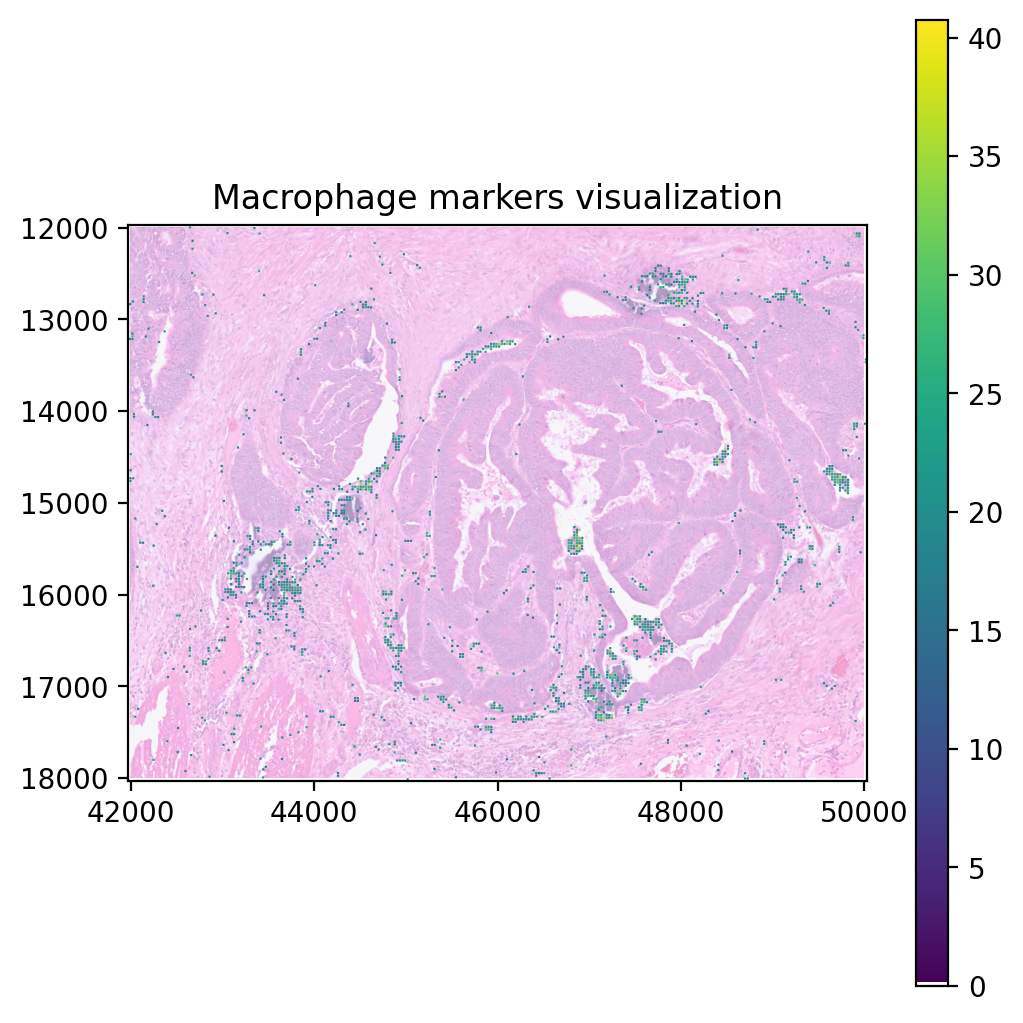

In [23]:
sdata_small.pl.render_images("queried_cytassist",alpha=0.4).pl.render_shapes(
        f"{sample_id}_square_00{bin_size}um", color="Macrophage",cmap=new_cmap,method="matplotlib",scale=0.8
    ).pl.show(coordinate_systems="global", title="Macrophage markers visualization", legend_fontsize=8,figsize=(5,5),dpi=200)

# Phase 2 - Load mid level clusters of macrophages
Here we are reading the markers from a dictionary and create a data frame based on these markers. This is different from what we did in the main demo notebook. We will use this data frame to detect clusters on the spatial data.

In [24]:
macro_clusters_dict= {"Cluster 0": ["IL1B", "CXCL8", "CCL3", "CCL4", "APOE", "C1QA", "C1QC", "MRC1", "SELENOP", "FOLR2", "F13A1", "LYVE1"],
"Cluster 1": ["S100A8", "S100A9", "CXCL8", "CCL3", "CCL4", "SPP1", "APOC1", "ACP5", "APOE", "C1QA", "C1QC", "MRC1"],
"Cluster 2": ["IL1B", "CXCL8", "CCL3", "CCL4", "APOC1", "ACP5", "APOE", "DNASE1L3", "C1QA", "C1QC", "MRC1", "SELENOP"],
"Cluster 3": ["S100A8", "S100A9", "IL1B"],
"Cluster 4": ["S100A8", "S100A9", "AQP9", "IL1B", "CXCL8", "CCL3", "CCL4"],
"Cluster 5": ["S100A8", "S100A9", "AQP9", "IL1B", "CXCL8", "CCL3", "CCL4", "HILPDA", "HIF1A-AS3"],
"Cluster 6": ["APOC1", "ACP5", "APOE", "C1QA", "C1QC"],
"Cluster 7": ["IL1B", "CXCL8", "CCL3", "CCL4", "ACP5", "APOE", "DNASE1L3", "C1QA", "C1QC", "MRC1", "SELENOP", "FOLR2", "F13A1"],
"Cluster 8": ["S100A8", "S100A9", "AQP9", "IL1B", "CXCL8", "CCL3", "CCL4", "CXCL10", "GBP1", "CXCL9", "IDO1", "ACP5", "C1QA", "C1QC", "MRC1"],
"Cluster 9": ["IL1B", "CXCL8", "CCL3", "CCL4", "C1QA", "C1QC", "MRC1", "FCER1A", "CD1C"],
"Cluster 10": ["SPP1", "APOC1", "ACP5", "APOE", "C1QA", "C1QC", "MRC1", "SELENOP", "FOLR2", "F13A1", "TOP2A", "MKI67"]}

macro_df = pd.DataFrame(list(macro_clusters_dict.items()), columns=['Cluster', 'names']).explode('names').reset_index(drop=True)
macro_df.set_index('Cluster', inplace=True)

In [25]:
#we are going to use overlap similarity method to find the clusters, weighted Jaccard is usually the standard but rank of the genes is not important in this case
df_cluster_overlap_macro=get_clusters_by_similarity_on_tissue(sdata_small,markers_df=macro_df,common_group_name="Macrophage",method="overlap")

Processing spots with Macrophage != 0
Number of threads used: 5
Batch size: 1000


100%|██████████| 1596/1596 [00:06<00:00, 256.07it/s]


Adding results to table.obs of sdata object


In [26]:
#These are also written to the sdata object
df_cluster_overlap_macro.head(10)

Cluster 0  Cluster 1  Cluster 2  Cluster 3  Cluster 4  \
s_008um_00219_00193-1   0.166667   0.250000   0.250000   0.000000   0.000000   
s_008um_00220_00285-1   0.166667   0.250000   0.250000   0.000000   0.000000   
s_008um_00190_00220-1   0.250000   0.500000   0.333333   0.333333   0.142857   
s_008um_00247_00288-1   0.333333   0.250000   0.333333   0.000000   0.000000   
s_008um_00333_00291-1   0.250000   0.333333   0.250000   0.000000   0.142857   
s_008um_00274_00084-1   0.250000   0.333333   0.250000   0.000000   0.000000   
s_008um_00181_00205-1   0.166667   0.333333   0.250000   0.000000   0.000000   
s_008um_00233_00100-1   0.166667   0.333333   0.250000   0.000000   0.142857   
s_008um_00247_00111-1   0.333333   0.250000   0.333333   0.000000   0.000000   
s_008um_00307_00165-1   0.083333   0.166667   0.083333   0.000000   0.142857   

                       Cluster 5  Cluster 6  Cluster 7  Cluster 8  Cluster 9  \
s_008um_00219_00193-1   0.000000        0.6   0.230769   0.200000   0.222222   
s_008um_00220_00285-1   0.000000        0.4   0.230769   0.133333   0.111111   
s_008um_00190_00220-1   0.222222        0.8   0.230769   0.200000   0.333333   
s_008um_00247_00288-1   0.000000        0.6   0.307692   0.133333   0.222222   
s_008um_00333_00291-1   0.111111        0.4   0.230769   0.200000   0.222222   
s_008um_00274_00084-1   0.111111        0.6   0.230769   0.133333   0.222222   
s_008um_00181_00205-1   0.000000        0.6   0.153846   0.066667   0.111111   
s_008um_00233_00100-1   0.111111        0.4   0.230769   0.133333   0.111111   
s_008um_00247_00111-1   0.000000        0.4   0.307692   0.133333   0.222222   
s_008um_00307_00165-1   0.111111        0.2   0.076923   0.066667   0.000000   

                       Cluster 10  
s_008um_00219_00193-1    0.250000  
s_008um_00220_00285-1    0.333333  
s_008um_00190_00220-1    0.416667  
s_008um_00247_00288-1    0.333333  
s_008um_00333_00291-1    0.250000  
s_008um_00274_00084-1    0.333333  
s_008um_00181_00205-1    0.333333  
s_008um_00233_00100-1    0.250000  
s_008um_00247_00111-1    0.333333  
s_008um_00307_00165-1    0.166667

### Now we can assign clusters using overlap similarity data frame

INFO     Using matplotlib                                                                                          


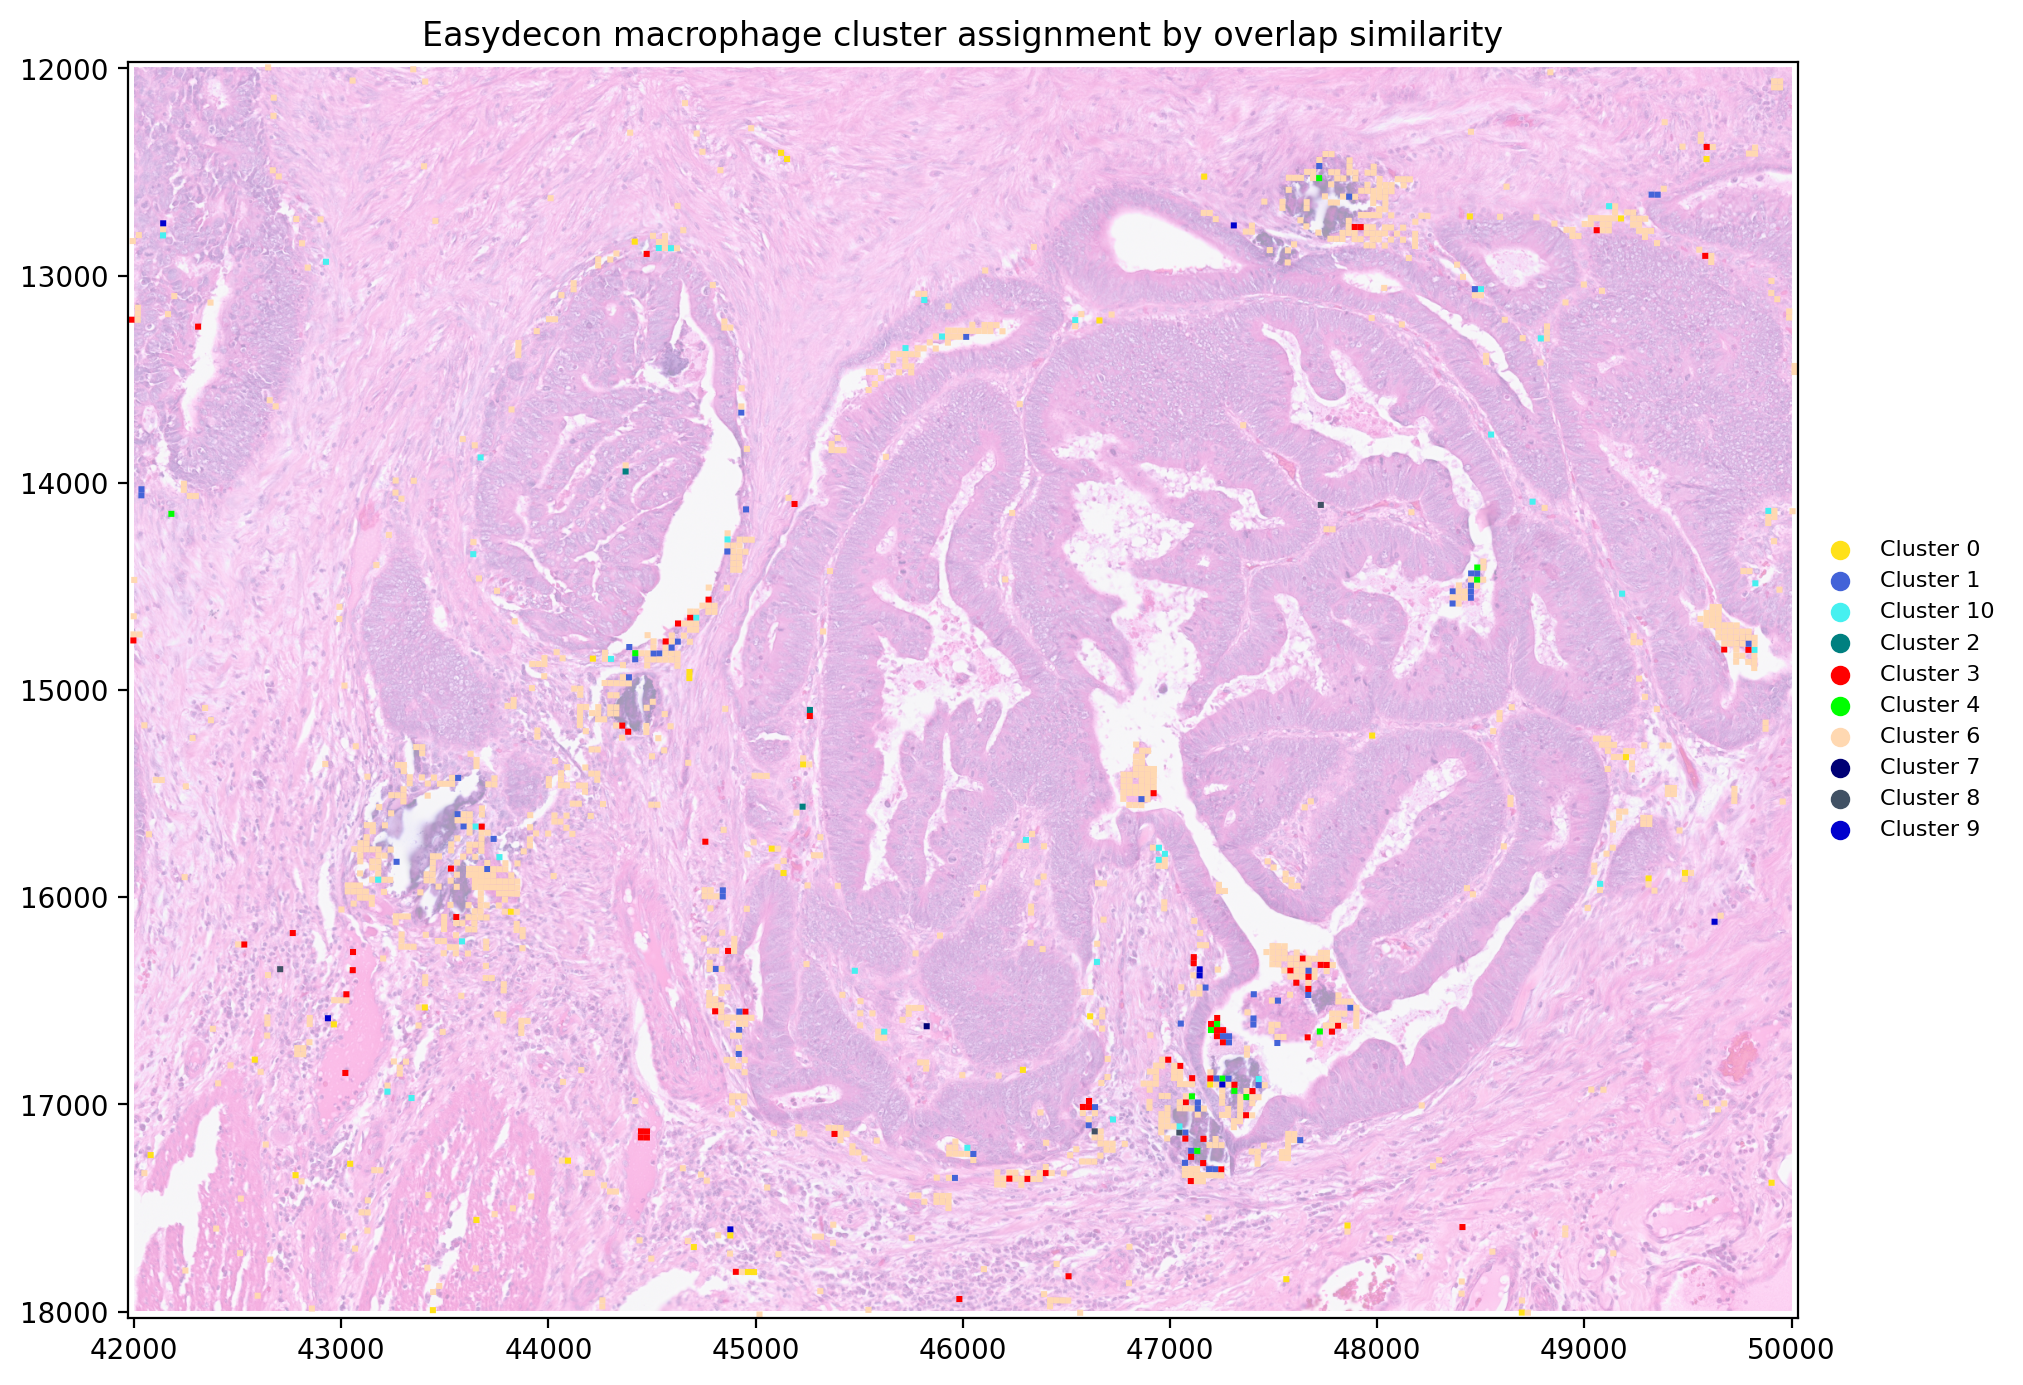

In [27]:
assign_clusters_from_df(sdata_small,df=df_cluster_overlap_macro,bin_size=8,results_column="overlapsimilarity")


sdata_small.pl.render_images("queried_cytassist",alpha=0.4).pl.render_shapes(
            f"{sample_id}_square_00{bin_size}um", color="overlapsimilarity",method="matplotlib",scale=1,na_color= (0.0, 0.0, 0.0, 0.0),cmap=discrete_cmap
        ).pl.show(coordinate_systems="global", title="Easydecon macrophage cluster assignment by overlap similarity",na_in_legend=False, legend_fontsize=8,figsize=(10,10),dpi=200,save=None)


# Phase - Downstream analysis

In [28]:
table=sdata_small["square_008um"][~sdata_small["square_008um"].obs["overlapsimilarity"].isna()].copy()

In [29]:
sq.gr.spatial_neighbors(table)

In [30]:
sq.gr.nhood_enrichment(table, cluster_key="overlapsimilarity")

100%|██████████| 1000/1000 [00:04<00:00, 209.17/s]
/Users/sium/miniconda/envs/easydecon_test1/lib/python3.11/site-packages/squidpy/gr/_nhood.py:194: RuntimeWarning: invalid value encountered in divide
  zscore = (count - perms.mean(axis=0)) / perms.std(axis=0)


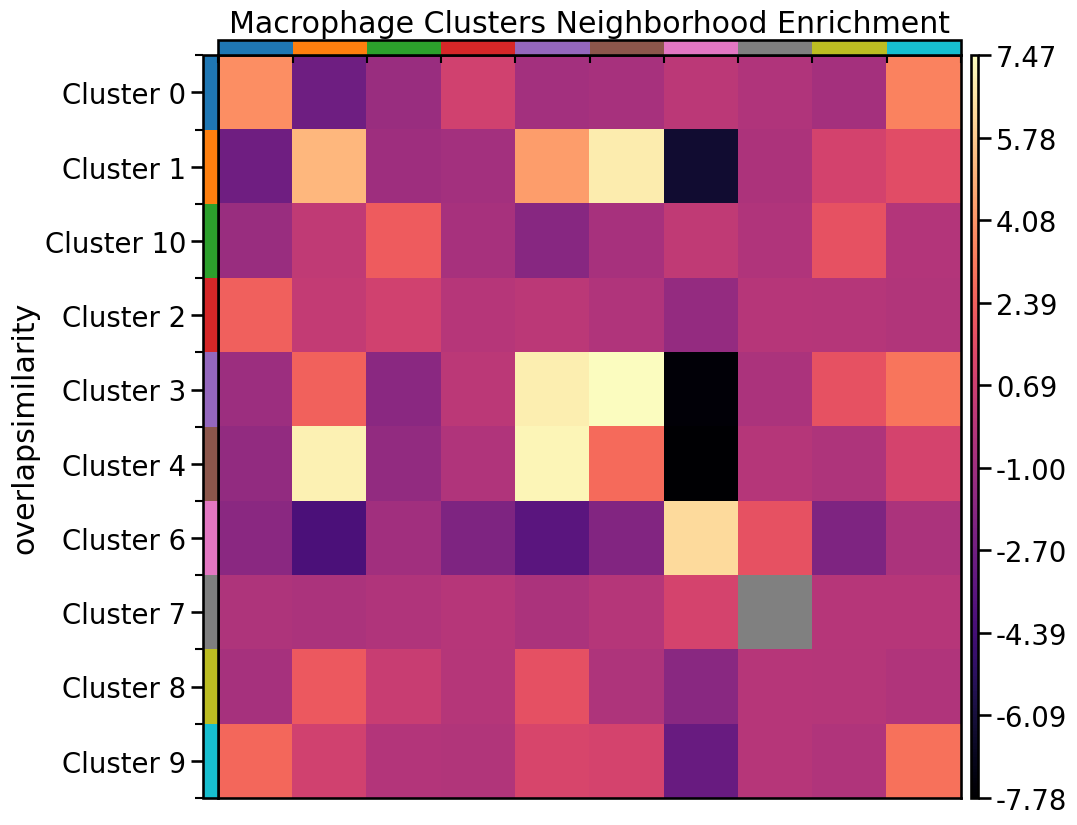

In [31]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set a context with larger font sizes for labels
sns.set_context("talk", font_scale=1.2)

fig, ax = plt.subplots(figsize=(10, 10))
sq.pl.nhood_enrichment(
    table, 
    cluster_key="overlapsimilarity", 
    ax=ax, 
    mode="zscore", 
    show=False, 
    title="Macrophage Clusters Neighborhood Enrichment",
    cmap="magma"
)
ax.yaxis.label.set_visible(False)
ax.set_ylabel("")

#plt.savefig(f"{sample_id}_neighborhood_macrophages.pdf", dpi=300, bbox_inches="tight")
plt.show()

In [32]:
sq.gr.co_occurrence(table, cluster_key="overlapsimilarity")


100%|██████████| 1/1 [00:04<00:00,  4.24s/]


ERROR: Unable to fetch palette, reason: 'overlapsimilarity_colors'. Using `None`.


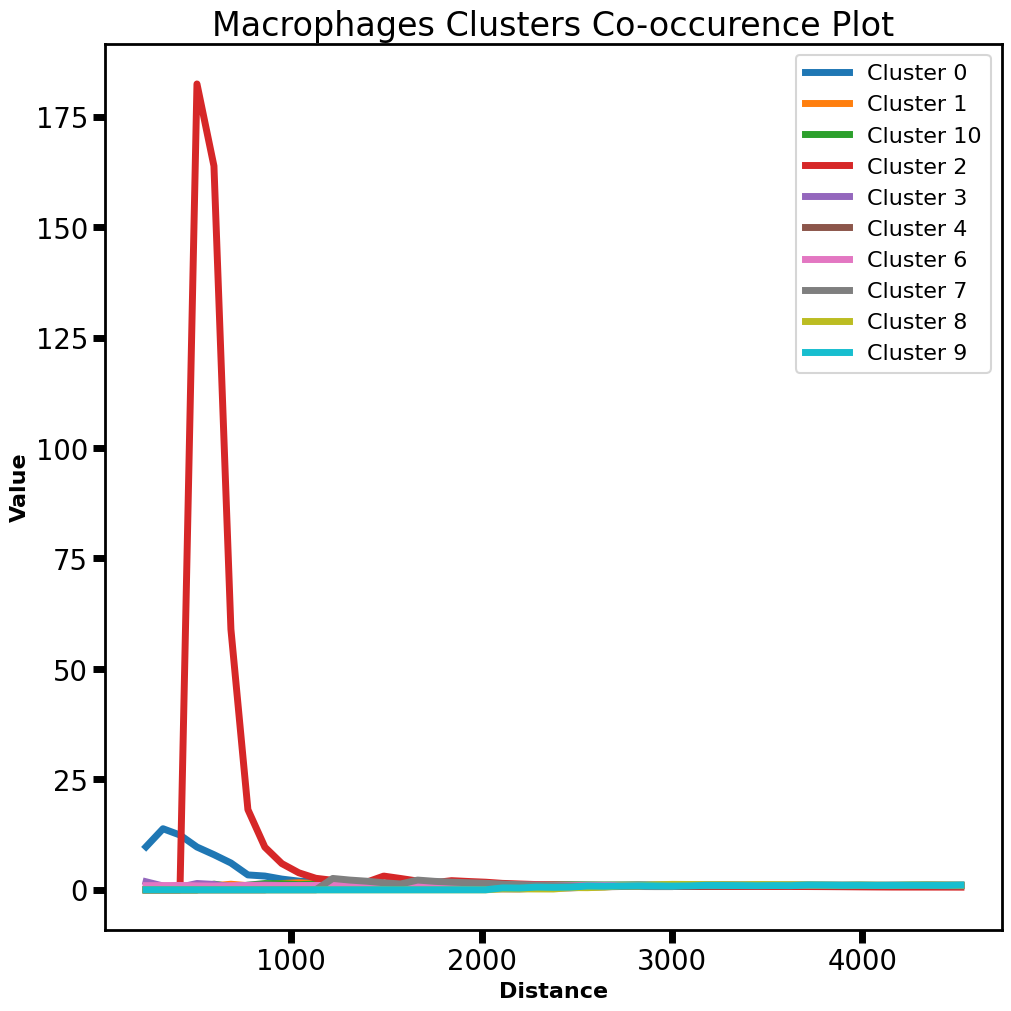

In [33]:
import matplotlib as mpl
import matplotlib.pyplot as plt

# Set the default line width for most line objects
mpl.rcParams['lines.linewidth'] = 5

sq.pl.co_occurrence(
    table, 
    cluster_key="overlapsimilarity", 
    clusters="Cluster 2",
    legend_kwargs={
        "loc": "upper right", 
        "bbox_to_anchor": (1, 1),
        "fontsize": 16
    },
    figsize=(10, 10)
)

ax = plt.gca()

# Increase the thickness of axis spines (the border lines of the plot)
for spine in ax.spines.values():
    spine.set_linewidth(2)

# Increase the thickness of the tick marks on both axes
ax.tick_params(width=5)

# Optionally, adjust the axis label font size and weight if needed
ax.xaxis.label.set_fontsize(16)
ax.yaxis.label.set_fontsize(16)
ax.xaxis.label.set_fontweight('bold')
ax.yaxis.label.set_fontweight('bold')
ax.set_ylabel("Value")
ax.set_xlabel("Distance")
# Set the title with a larger font size
ax.set_title("Macrophages Clusters Co-occurence Plot", fontsize=24)

#plt.savefig(f"{sample_id}_cooccurrence_macrophages.pdf", dpi=300, bbox_inches="tight")
plt.show()